In [ ]:
from PIL import Image
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import tensorflow as tf
import soundfile as sf
from keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
size = (1025, 430)

In [ ]:
content_path = "Music/Trumpet.wav"
style_path = "Music/Bach.wav"

In [ ]:
x, sr = librosa.load(content_path)
display(Audio(x, rate=22050))
x, sr = librosa.load(style_path)
display(Audio(x, rate=22050))

In [ ]:
def audio_to_img(path, size):
    x, sr = librosa.load(path)
    stft = librosa.stft(x)
    mag, phase = librosa.magphase(stft)  
    mag = np.log1p(mag)

    mag_min, mag_max = mag.min(), mag.max()
    mag_norm = (mag - mag_min) / (mag_max - mag_min)

    mag_norm = mag_norm[:size[0], :size[1]]

    data = (mag_norm * 255).astype(np.uint8)
    img = Image.fromarray(data, mode='L')

    return img, mag_min, mag_max, phase

In [ ]:
def image_to_audio(img, mag_min, mag_max):
    mag_norm = np.array(img, dtype=np.float32) / 255
    mag = mag_norm * (mag_max - mag_min) + mag_min
    mag = np.exp(mag) - 1
    return librosa.griffinlim(mag)

In [ ]:
content_img, mag_min, mag_max, phase = audio_to_img(content_path, size)
style_img, _, _, _ = audio_to_img(style_path, size)

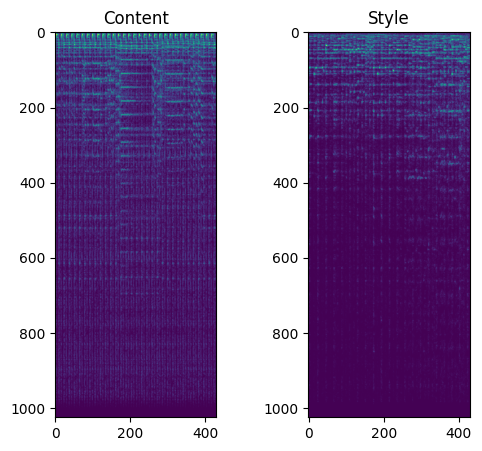

In [ ]:
plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content_img)

plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style_img)

plt.show()

In [ ]:
content_np = np.array(content_img).T[None, None, :, :]
style_np = np.array(style_img).T[None, None, :, :]

content_tensor = tf.convert_to_tensor(content_np, dtype=tf.float32)
style_tensor = tf.convert_to_tensor(style_np, dtype=tf.float32)

In [ ]:
BATCH, HEIGHT, WIDTH, CHANNELS = content_tensor.shape
FILTERS = 4096

input_shape = (HEIGHT, WIDTH, CHANNELS)

In [ ]:
def custom_kernel_initializer(shape, dtype=None):
    std = np.sqrt(2) * np.sqrt(2.0 / ((CHANNELS + FILTERS) * 11))
    kernel = np.random.randn(1, 11, shape[-2], shape[-1]) * std
    return tf.constant(kernel, dtype=dtype)

In [ ]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    outputs = Conv2D(
        filters=FILTERS, 
        kernel_size=(1, 11), 
        padding='same', 
        activation='relu', 
        kernel_initializer=custom_kernel_initializer
    )(inputs)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
model = create_model(input_shape)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 430, 1025)]    0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 430, 4096)      46186496  
                                                                 
Total params: 46,186,496
Trainable params: 46,186,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def gram_matrix(x):
    feats = tf.reshape(x, (-1, x.shape[-1]))
    return tf.matmul(tf.transpose(feats), feats)
 
def get_style_loss(A, B):
    gram_A = gram_matrix(A)
    gram_B = gram_matrix(B)
    return tf.sqrt(tf.reduce_sum(tf.square(gram_A - gram_B)))

def get_content_loss(A, B):
    return tf.sqrt(tf.reduce_sum(tf.square(A - B)))

In [ ]:
content_features = model(content_tensor)
style_features = model(style_tensor)

In [ ]:
gen_np = tf.random.normal((1, *input_shape))
gen = tf.Variable(gen_np) 

steps_counter = 0

In [ ]:
STEPS = 5000

optimizer = Adam(learning_rate=1)


for i in range(STEPS):
    with tf.GradientTape() as tape:
        tape.watch(gen)

        gen_features = model(gen)

        content_loss = get_content_loss(gen_features, content_features)
        style_loss = get_style_loss(gen_features, style_features) * 0.001

        loss = content_loss + style_loss
        
    gradients = tape.gradient(loss, [gen])
    optimizer.apply_gradients(zip(gradients, [gen]))
    
    if i % 50 == 0:
        print(f"Step: {i} | loss: {loss.numpy()} | {content_loss.numpy()} | {style_loss.numpy()}")

steps_counter += STEPS

Step: 0 | loss: 22789.724609375 | 18407.6328125 | 4382.091796875
Step: 50 | loss: 22728.728515625 | 18303.177734375 | 4425.55029296875
Step: 100 | loss: 22549.37109375 | 18364.41796875 | 4184.95361328125
Step: 150 | loss: 22454.029296875 | 18375.8515625 | 4078.177001953125
Step: 200 | loss: 22423.044921875 | 18368.896484375 | 4054.147705078125
Step: 250 | loss: 22281.5 | 18362.029296875 | 3919.470947265625
Step: 300 | loss: 22348.923828125 | 18358.0078125 | 3990.916015625
Step: 350 | loss: 22253.345703125 | 18352.314453125 | 3901.031494140625
Step: 400 | loss: 22241.763671875 | 18347.462890625 | 3894.300537109375
Step: 450 | loss: 22174.720703125 | 18342.060546875 | 3832.65966796875
Step: 500 | loss: 22123.607421875 | 18338.86328125 | 3784.744140625
Step: 550 | loss: 22150.37890625 | 18337.6015625 | 3812.77783203125
Step: 600 | loss: 22104.44140625 | 18335.1484375 | 3769.292236328125
Step: 650 | loss: 22028.3828125 | 18332.224609375 | 3696.158203125
Step: 700 | loss: 22037.767578125 | 

In [ ]:
gen_np = np.squeeze(gen.numpy()).T
gen_img = Image.fromarray(gen_np).convert('L')

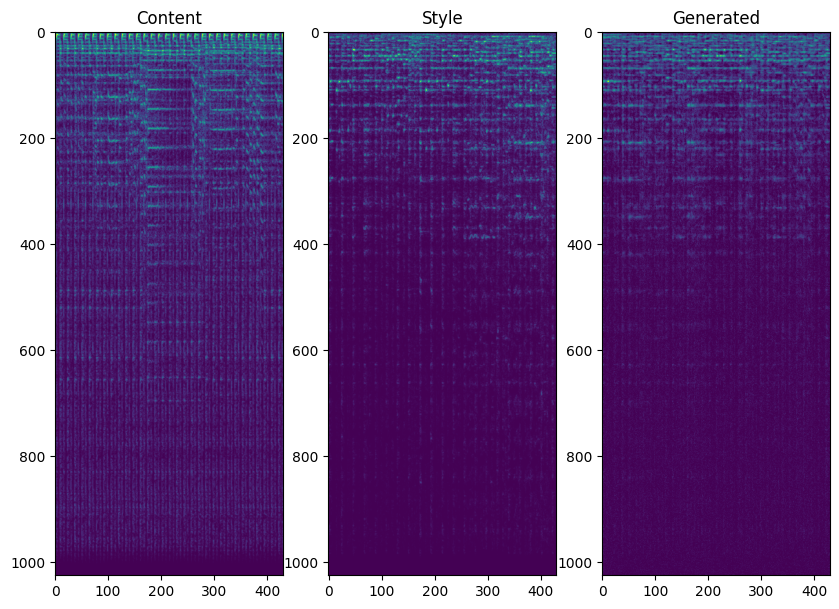

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.title("Content")
plt.imshow(content_img)

plt.subplot(1, 3, 2)
plt.title("Style")
plt.imshow(style_img)

plt.subplot(1, 3, 3)
plt.title("Generated")
plt.imshow(gen_img)

plt.show()

In [ ]:
x = image_to_audio(gen_img, mag_min, mag_max)
display(Audio(x, rate=22050))

In [ ]:
gen_img.convert('RGB').save('ouput.jpg')
np.save(f'weights.npy', gen.numpy())
sf.write(f'output.mp3', x, 22050)